In [0]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/35/1c/e41fee54ec90e1e3c4ee7871710b8c370fa02a54cb09979aa140e0abec16/pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df_pandas = pd.read_csv(url, header=0, parse_dates=['Month'], index_col='Month')

In [0]:
spark = SparkSession.builder.appName("AirlinePassengerForecasting").getOrCreate()
df_spark = spark.createDataFrame(df_pandas.reset_index())

In [0]:
df_spark.show(5)

+-------------------+----------+
|              Month|Passengers|
+-------------------+----------+
|1949-01-01 00:00:00|       112|
|1949-02-01 00:00:00|       118|
|1949-03-01 00:00:00|       132|
|1949-04-01 00:00:00|       129|
|1949-05-01 00:00:00|       121|
+-------------------+----------+
only showing top 5 rows



In [0]:
df_pandas = df_spark.toPandas()
df_pandas.set_index('Month', inplace=True)

In [0]:
train_size = int(len(df_pandas) * 0.8)
train, test = df_pandas[:train_size], df_pandas[train_size:]

In [0]:
model = auto_arima(train, seasonal=True, m=12)  # m=12 for monthly data
model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [0]:
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])
conf_int_df = pd.DataFrame(conf_int, index=test.index, columns=['Lower CI', 'Upper CI'])

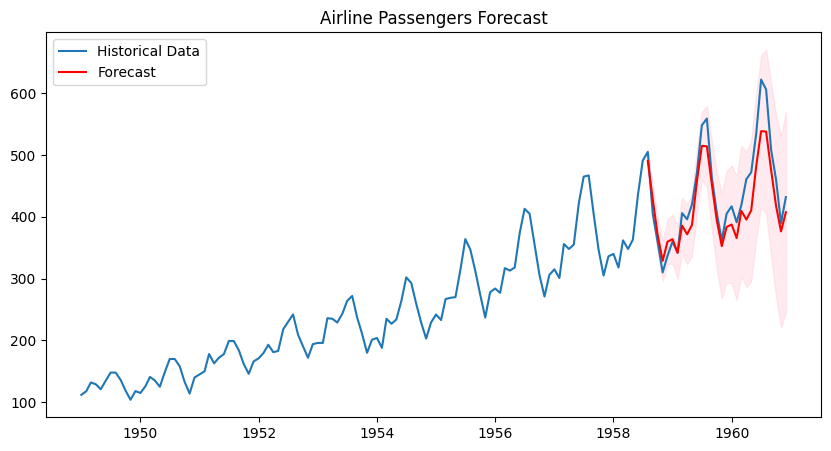

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(df_pandas.index, df_pandas['Passengers'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(conf_int_df.index, conf_int_df['Lower CI'], conf_int_df['Upper CI'], color='pink', alpha=0.3)
plt.title('Airline Passengers Forecast')
plt.legend()
plt.show()


In [0]:
# RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Test RMSE: {rmse}")

# MAE
mae = mean_absolute_error(test, forecast)
print(f"Test MAE: {mae}")

# MSE
mse = mean_squared_error(test, forecast)
print(f"Test MSE: {mse}")

# R-squared
r2 = r2_score(test, forecast)
print(f"Test R-squared: {r2}")

Test RMSE: 35.08281305366807
Test MAE: 28.5474087597444
Test MSE: 1230.8037717586228
Test R-squared: 0.7983772938713357
